In [1]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd

In [11]:
#------ EQUATIONS FOR OUR THEORY ------

# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    h , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_r = 2.47e-5 * h**(-2)
    
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    h , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_r = 2.47e-5 * h**(-2)
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    if alpha_tilde == 0:
        return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        return np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))
    
# Used to find z_CMB
def g1(Omgb_hsquared):
    return (0.0783*(Omgb_hsquared)**(-0.238))/\
           (1 + 39.5*Omgb_hsquared**(0.763))

# Used to find z_CMB
def g2(Omgb_hsquared):
    return 0.56/(1 + 21.1*Omgb_hsquared**(1.81))

# redshift at which the BB occurs
def z_CMB(Omgb_hsquared):
    return 1048*(1+0.00124*Omgb_hsquared**(-0.738))*\
           (1 + g1(Omgb_hsquared)*Omgb_hsquared**g2(Omgb_hsquared))

# Used to find r_s
def R_b(Omgb_hsquared):
    return 31500*Omgb_hsquared*(2.275/2.7)**(-4)

# Shift parameter
def R(z, cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b*h**2))[0]

# Acoustic scale
def l_A(z, cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b*h**2))[0]/\
           scipy.integrate.quad(lambda x: 1/(x*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2))*x)), 0 , 1/(1+z))[0]

""" OLD FUNCTIONS
# Angular diameter distance
def D_A(z, cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    H0 = 100*h/(3.086e19) # /s
    c = 3e8
    return scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z)[0]/(H0*(1+z))

# Comoving sound horizon (to find acoustic scale)
def r_s(z, cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    H0 = 100*h/(3.086e19) # /s
    ans = scipy.integrate.quad(lambda x: 1/(x*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2))*x)), 0 , 1/(1+z))[0]/H0
    return ans

# Shift parameter
def R(z, cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    H0 = 100*h/(3.086e19) # /s
    Omg_m = Omg_b + Omg_c
    return np.sqrt(Omg_m*H0**2)*(1+z_CMB(Omg_b*h**2))*D_A(z_CMB(Omg_b*h**2), cosmo)

# Acoustic scale
def l_A(z, cosmo):
    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    H0 = 100*h/(3.086e19) # /s
    return (1+z_CMB(Omg_b*h**2))*np.pi*D_A(z_CMB(Omg_b*h**2), cosmo)/r_s(z_CMB(Omg_b*h**2),cosmo)
"""

' OLD FUNCTIONS\n\n\n# Angular diameter distance\ndef D_A(z, cosmo):\n    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo\n    H0 = 100*h/(3.086e19) # /s\n    c = 3e8\n    return scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z)[0]/(H0*(1+z))\n\n# Comoving sound horizon (to find acoustic scale)\ndef r_s(z, cosmo):\n    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo\n    H0 = 100*h/(3.086e19) # /s\n    ans = scipy.integrate.quad(lambda x: 1/(x*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2))*x)), 0 , 1/(1+z))[0]/H0\n    return ans\n\n# Shift parameter\ndef R(z, cosmo):\n    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo\n    H0 = 100*h/(3.086e19) # /s\n    Omg_m = Omg_b + Omg_c\n    return np.sqrt(Omg_m*H0**2)*(1+z_CMB(Omg_b*h**2))*D_A(z_CMB(Omg_b*h**2), cosmo)\n\n# Acoustic scale\ndef l_A(z, cosmo):\n    h , Omg_b , Omg_c , Omg_k , alpha_t = cosmo\n    H0 = 100*h/(3.086e19) # /s\n    return (1+z_CMB(Omg_b*h**2))*np.pi*D_A(z_CMB(Omg_b*h**2), cosmo)/r_s(z_CMB(Omg_b*h**2),cosmo)\n'

In [12]:
def log_likelihood(theta, x, y, C_CMB_10e8):
    Omg_b, Omg_c , H0 = theta 
    z = z_CMB(Omg_b*(H0/100)**2)
    cosmo = [H0 , Omg_b , Omg_c , 0 , 0]
    model = [R(z, cosmo) , l_A(z, cosmo) , Omg_b*(H0/100)**2]
    return -0.5 * 1e-3 * np.matmul(np.matmul((y-model),np.linalg.inv(C_CMB_10e8)),np.transpose(y-model))

In [13]:
def log_prior(theta):
    Omg_b, Omg_c , h  = theta
    if 0.0 < Omg_b < 0.9 and 0.1 < Omg_c < 0.9 and 0.5 < h < 1:
        return 0.0
    return -np.inf

In [14]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [15]:
#get the data

# Choose the seed parameters.
Omg_b_est = 0.1
Omg_c_est = 0.1
h_est = 0.7

# Our data: y = [R , l_a , Omgb_hsquared] at z_CMB, and our Covariance matrix * 1e8
C_CMB_10e8 = 1e-8*np.array([[1598.9554 , 17112.007 , -36.311179],
              [17112.007 , 811208.45 , -494.79813],
              [-36.311179 , -494.79813 , 2.1242182]])
y = np.array([1.74963, 301.80845, 0.02237])
x = [0,0,0] #a dummy variable
"""
plt.errorbar([z_CMB(Omg_b_est*(H0_est/100)**2),z_CMB(Omg_b_est*(H0_est/100)**2),z_CMB(Omg_b_est*(H0_est/100)**2)],\
             y, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.xlabel("z_CMB")
plt.ylabel("Data(z_CMB)");
"""

'\nplt.errorbar([z_CMB(Omg_b_est*(H0_est/100)**2),z_CMB(Omg_b_est*(H0_est/100)**2),z_CMB(Omg_b_est*(H0_est/100)**2)],             y, fmt=".k", capsize=0)\nx0 = np.linspace(0, 10, 500)\nplt.xlabel("z_CMB")\nplt.ylabel("Data(z_CMB)");\n'

In [24]:
# Test equations and data are sensible for some fiducial cosmology

# Choose the fiducial parameters.
Omg_b_fid = np.linspace(0.0001,0.07,int(2e1))
Omg_c_fid = np.linspace(0, 0.54, int(2e1))
h_fid = np.linspace(0.50, 1, int(2e1))

likelihood_fid = np.zeros((len(Omg_b_fid),len(Omg_c_fid), len(h_fid)))

for i in range(len(Omg_b_fid)):
    for j in range(len(Omg_c_fid)):
        for k in range(len(h_fid)):
            z_fid = z_CMB(Omg_b_fid[i]*h_fid[k]**2)
            cosmo_fid = [h_fid[k] , Omg_b_fid[i] , Omg_c_fid[j] , 0 , 0]
            model_fid = [R(z_fid, cosmo_fid) , l_A(z_fid, cosmo_fid) , Omg_b_fid[i]*h_fid[k]**2]
            likelihood_fid[i][j][k] = -0.5 * np.matmul(np.matmul((y-model_fid),np.linalg.inv(C_CMB_10e8)),np.transpose(y-model_fid))


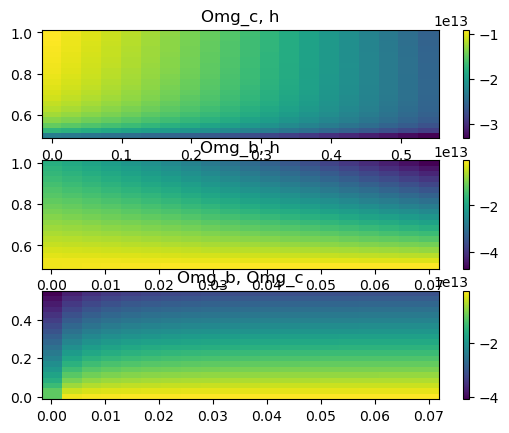

In [25]:
# plot likelihood function

X1, Y1 = np.meshgrid(Omg_c_fid, h_fid)
Z1 = likelihood_fid[int(10),:,:]
X2, Y2 = np.meshgrid(Omg_b_fid,h_fid)
Z2 = likelihood_fid[:,int(10),:]
X3, Y3 = np.meshgrid(Omg_b_fid,Omg_c_fid)
Z3 = likelihood_fid[:,:,int(10)]

fig, axs = plt.subplots(3)

ax = axs[0]
c = ax.pcolor(X1, Y1, Z1)
ax.set_title('Omg_c, h')
fig.colorbar(c, ax=ax)

ax = axs[1]
c = ax.pcolormesh(X2, Y2, Z2)
ax.set_title('Omg_b, h')
fig.colorbar(c, ax=ax)

ax = axs[2]
c = ax.pcolormesh(X3,Y3,Z3)
ax.set_title('Omg_b, Omg_c')
fig.colorbar(c, ax=ax)

plt.show()

In [26]:
# fractional error

print("dR = ", (y[0]- R(z_CMB(Omg_b_fid[10]*h_fid[10]**2), [h_fid[10] , Omg_b_fid[10] , Omg_c_fid[10] , 0 , 0]))/y[0])
print("dl_a = " ,(y[1] - l_A(z_CMB(Omg_b_fid[10]*h_fid[10]**2), [h_fid[10] , Omg_b_fid[10] , Omg_c_fid[10] , 0 , 0]))/y[1])
print("dOmgbh2 = ",(y[2] - Omg_b_fid[10]*h_fid[10]**2)/y[2])


dR =  -0.004156502015889995
dl_a =  -1515.3823099910194
dOmgbh2 =  0.03957097243844537


In [19]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_b_est, Omg_c_est , h_est] + 1e-2 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, C_CMB_10e8)
)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/c2042999/anaconda3/envs/4DEGB_virtualenv/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1000/1000 [01:16<00:00, 13.05it/s]


(3000, 3)


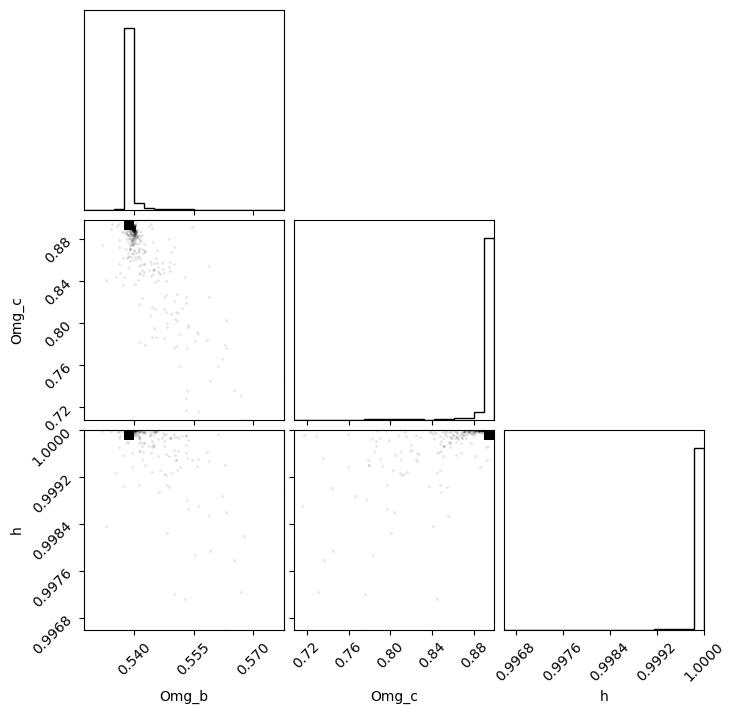

In [20]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["Omg_b", "Omg_c", "h"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[Omg_b_est, Omg_c_est, h_est]
);

50
1000
3
1000


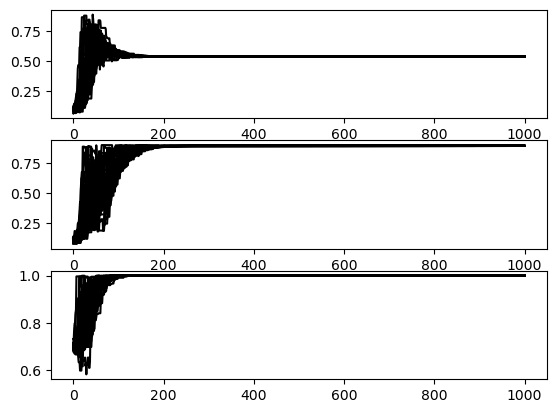

In [21]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")


In [22]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>